In [1]:
import dgl
import torch
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

Using backend: pytorch


In [2]:
from dgl.nn.pytorch import GraphConv

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g,h):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        #h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.sum_nodes(g, 'h')
        return self.classify(hg)

In [13]:
print(model)

Classifier(
  (conv1): GraphConv(in=17, out=64, normalization=both, activation=None)
  (conv2): GraphConv(in=64, out=64, normalization=both, activation=None)
  (classify): Linear(in_features=64, out_features=3, bias=True)
)


In [14]:
for name, parameters in model.named_parameters():
    print(name, ':', parameters.size())

conv1.weight : torch.Size([17, 64])
conv1.bias : torch.Size([64])
conv2.weight : torch.Size([64, 64])
conv2.bias : torch.Size([64])
classify.weight : torch.Size([3, 64])
classify.bias : torch.Size([3])


In [4]:
import torch.optim as optim
#from dataloader import GraphDataLoader

from torch.utils.data import DataLoader

In [5]:
import pickle
import random

# #data_2880_2021
# dataset_name1 = "/home/dldx/UniRep/dataset/data_2880_2021.p"
# with open("/home/dldx/UniRep/data/5fyj_1440.p", 'rb') as f:                      
#     graph = pickle.load(f)
# print(len(graph))

# dataset=[]
# for i in range(48):
#     dataset.append(graph[i*30])
# len(dataset)

In [6]:
# A4ZPX2
tied1_name_l = ['Q5G5V8','Q5G5V4','Q6EG58','A4ZPW4','P04578','Q4QXE8','A8CVW4','Q2MKA8','A1EAH8','A1EAI4','Q27Q69','Q70014','B2YFU9','B2YFQ5','O89960']
tied1_name_l.sort()
# A1EAI3
tied2_name_l = ['Q5G5U7','Q5G5U5','A7KVY7','Q5G5V1','B0FBI6','Q5G5V5','A1EAI2','A1EAI0','Q6TCV7','Q202K1','Q202K7','Q27Q74','A1EAI7','B2YFT0','Q8JDI3']
tied2_name_l.sort()
# A4ZPW9
tied3_name_l = ['A4ZPX1','A4ZPW7','A4ZPW8','Q5G5V2','Q5G5U6','A1EAG8','A1EAH7','A0MTL0','A1EAH6','A1EAH3','B2YFP6','B2YFP1','B2YFU4','B2YFV4','B2YFS0']
tied3_name_l.sort()
tied_name=tied1_name_l+tied2_name_l+tied3_name_l

In [7]:
# data45_true=[]
# for i in range(48):
#     name=dataset[i][-1].split('-')[1]
#     if name in tied_name:
#         data45_true.append(dataset[i])
        

In [8]:
with open("/home/dldx/UniRep/data/data45_true.p", 'rb') as f:                      
    graph = pickle.load(f)
print(len(graph))

45


In [9]:
# default collate function
def collate(samples):
    # The input `samples` is a list of pairs (graph, label).
    graphs, labels,_ = map(list, zip(*samples))
    for g in graphs:
        # deal with node feats
        for key in g.node_attr_schemes().keys():
            g.ndata[key] = g.ndata[key].float()
        # no edge feats
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    return batched_graph, labels

In [10]:
t1_loader = DataLoader(graph, batch_size=45, shuffle=True, collate_fn=collate)

In [54]:

# Use DGL's GraphDataLoader. It by default handles the
# graph batching operation for every mini-batch.
#data_loader = DataLoader(trainset, batch_size=32, collate_fn=collate,shuffle=True)

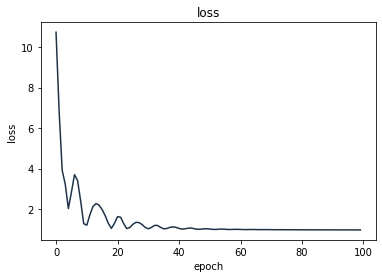

In [58]:
plt.plot(epoch_losses, color=(0.1,0.2,0.3))
# plt.xlim([0, 500])
# plt.ylim([0.0, 1.05])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
# plt.legend(loc="lower right")
plt.show()

In [55]:
t1_loader

In [11]:
#trainset.num_classes
# set up seeds, args.seed supported
import numpy as np
seed=2021
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)

#指定GPU
torch.cuda.set_device(1)
if torch.cuda.is_available():

    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed=seed)
else:
    device = torch.device("cpu")
print(device)
#device = torch.device("cpu")

cuda


In [12]:
# Create model
num_classes=3
model = Classifier(17, 64, num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_acc=[]
epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    total = 0
    total_loss = 0
    total_correct = 0
    for iter, (bg, label) in enumerate(t1_loader):
        feat = bg.ndata['feat'].float().to(device)
        label=label.to(device)
        prediction = model(bg,feat)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        total += len(label)
        _, predicted = torch.max(prediction.data, 1)
        total_correct += (predicted == label.data).sum().item()
    epoch_loss /= (iter + 1)
    acc = 1.0*total_correct / total
    epoch_acc.append(acc)
    epoch_losses.append(epoch_loss)
    print('Epoch {}, loss {:.4f}, acc {:.4f}'.format(epoch, epoch_loss, acc))


Epoch 0, loss 10.7374, acc 0.3333
Epoch 1, loss 6.8380, acc 0.3333
Epoch 2, loss 3.9146, acc 0.3556
Epoch 3, loss 3.2211, acc 0.3333
Epoch 4, loss 2.0257, acc 0.3333
Epoch 5, loss 2.8286, acc 0.3333
Epoch 6, loss 3.7000, acc 0.3333
Epoch 7, loss 3.4128, acc 0.3333
Epoch 8, loss 2.4076, acc 0.3333
Epoch 9, loss 1.2803, acc 0.3333
Epoch 10, loss 1.2021, acc 0.3556
Epoch 11, loss 1.7129, acc 0.3333
Epoch 12, loss 2.1206, acc 0.3333
Epoch 13, loss 2.2722, acc 0.3333
Epoch 14, loss 2.1928, acc 0.3333
Epoch 15, loss 1.9741, acc 0.3556
Epoch 16, loss 1.6682, acc 0.3556
Epoch 17, loss 1.2937, acc 0.3556
Epoch 18, loss 1.0466, acc 0.4667
Epoch 19, loss 1.2937, acc 0.3333
Epoch 20, loss 1.6273, acc 0.3333
Epoch 21, loss 1.5999, acc 0.3333
Epoch 22, loss 1.2823, acc 0.3333
Epoch 23, loss 1.0352, acc 0.3333
Epoch 24, loss 1.0894, acc 0.3556
Epoch 25, loss 1.2484, acc 0.3556
Epoch 26, loss 1.3437, acc 0.3333
Epoch 27, loss 1.3343, acc 0.3778
Epoch 28, loss 1.2335, acc 0.3333
Epoch 29, loss 1.0965, 

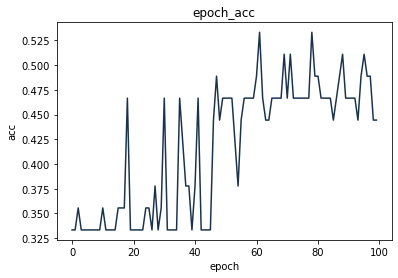

In [59]:
plt.plot(epoch_acc, color=(0.1,0.2,0.3))
# plt.xlim([0, 500])
# plt.ylim([0.0, 1.05])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('epoch_acc')
# plt.legend(loc="lower right")
plt.show()